# Introduction

Here we are giving a brief introduction to rasterizing shapefiles by rasterizing country ids into a given grid.

In [1]:
import xarray as xr
from descartes import PolygonPatch
import matplotlib.pyplot as plt
from fiona import collection

import ptolemy as pt

# Data

We generally begin with gridded data that we want our future raster to look like. Let's take an example from `xarray` looking at some data over North America.

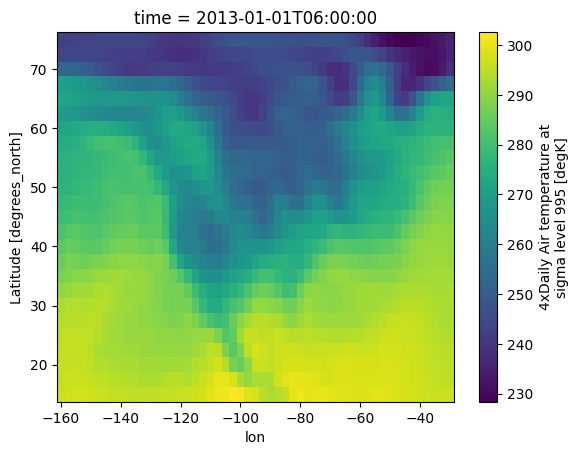

In [2]:
ds = xr.tutorial.load_dataset("air_temperature")
ds['lon'] = ds.lon - 360 # change from degrees_east to centered at prime meridian
grid = ds.air.isel(time=1)
grid.plot()

We can then pull out a shapefile dataset for country borders

In [3]:
url = "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_0_countries.geojson"

(-90.0, 90.0)

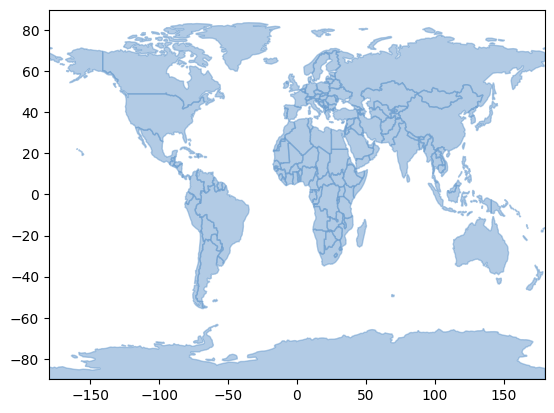

In [4]:
# let's take a look
BLUE = '#6699cc'
fig, ax = plt.subplots()
with collection(url, "r") as inp:
    for f in inp:
        patch = PolygonPatch(f['geometry'], fc=BLUE, ec=BLUE, alpha=0.5)
        ax.add_patch(patch)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

# Rasterize with Ptolemy

The basic steps are to great a `Rasterize` object, tell it what shapefile you want to rasterize, and what strategy you want to use to do the rasterization.

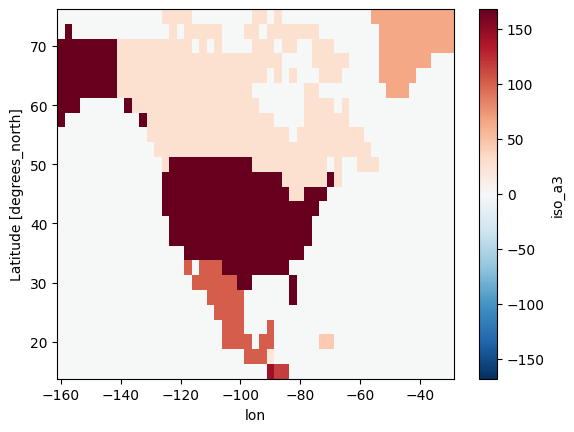

In [5]:
r = pt.Rasterize(like=grid)
r.read_shpf(url, idxkey="iso_a3")
idxr_c = r.rasterize(strategy="centroid", verbose=True)
idxr_c.plot() # idxr_c is an xr.DataArray

We can also use an 'all-touched' approach

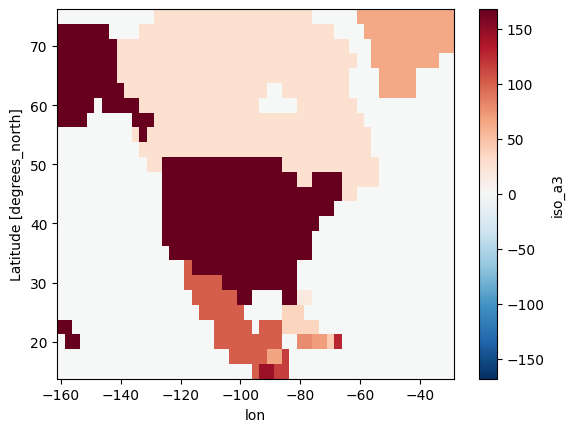

In [6]:
r = pt.Rasterize(like=grid)
r.read_shpf(url, idxkey="iso_a3")
idxr_at = r.rasterize(strategy="all_touched", verbose=True)
idxr_at.plot()

and see the differences

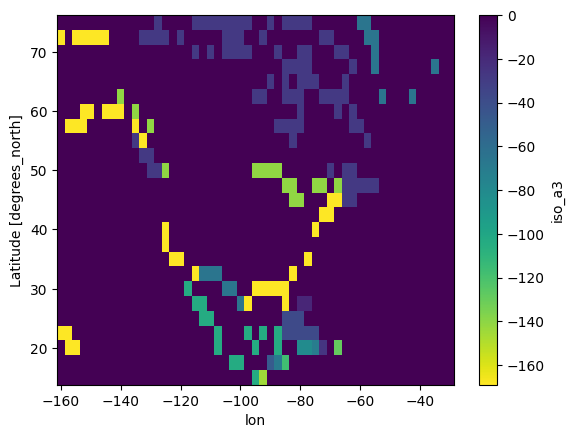

In [7]:
(idxr_c - idxr_at).plot(cmap='viridis_r')

# Advanced Rasterization Approaches

- "majority"
- "majority_ignore_nodata"
- "hybrid"
- "weighted"

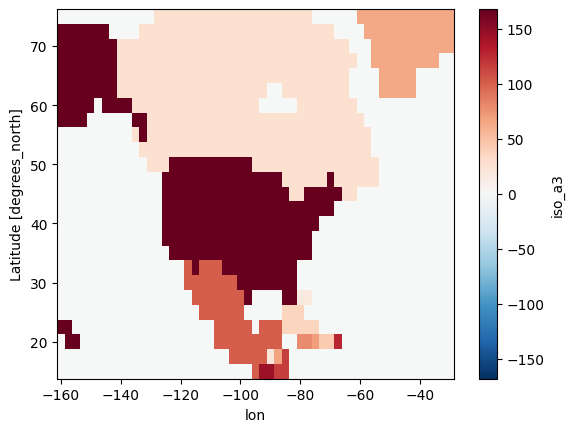

In [8]:
r = pt.Rasterize(like=grid)
r.read_shpf(url, idxkey="iso_a3")
idxr_h = r.rasterize(strategy="hybrid", verbose=True)
idxr_h.plot()

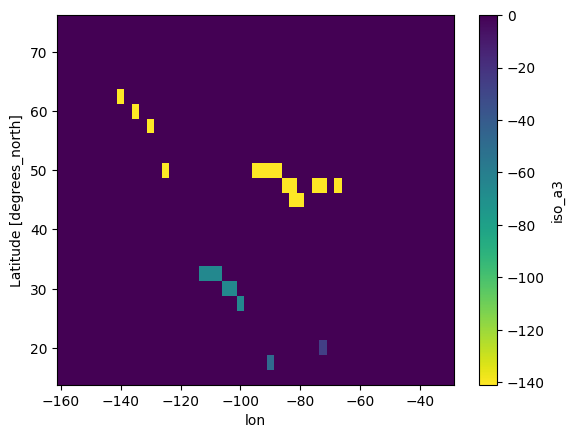

In [9]:
(idxr_h - idxr_at).plot(cmap='viridis_r')

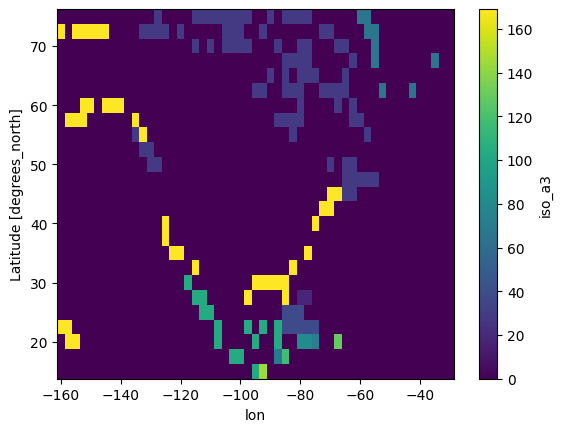

In [10]:
(idxr_h - idxr_c).plot()